# Example 4

This is an example that reproduces Figure 4 from M Genkin, O Hughes, TA Engel ArXiv 2020. First, we generate synthetic data from ramping and stepping dynamics and optimize the model on these data, and visualise the results. Next, we perform simultaneous inference of model potential, diffusion coefficient, and initial distribution of latent states from data generated from a ramping dynamics.

In [1]:
import neuralflow
import numpy as np
import matplotlib.pyplot as plt, matplotlib.gridspec as gridspec
from neuralflow.utilities.visualization_functions import plot_spikes, plot_fitting_results
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Step 1: Generate synthetic data from ramping and stepping models.

1) Specify the ground-truth model for data generation, see the implementation of the `EnergyModel` class for available options.

2) Specify additional data generation parameters. Here we will generate 400 trials of data, each trial will have 100 seconds maximum duration (however, all of them will terminate earlier due to absorption at the decision boundary, with the average trial duration time less than 1 second). We will use time step `deltaT = 0.0001` for the Euler–Maruyama numerical integration of the Langevin equation. We also set the parameter `last_event_is_spike` to False in order to record the trial termination time.  

3) Perform data generation

4) (OPTIONAL) Visualize latent trajectories and spike rasters of the generated data. First of all, for each of the 400 generated latent trajectories, find the termination side (left or right boundary). Select 3 example trials where the latent trajectory terminated on the left, and 6 trials where the latent trajectory terminated on the right boundary. Plot latent trajectories and the corresponding spike rasters for the example nine trials.

In [2]:
data_gen_params={'deltaT':0.0001, 'time_epoch':  [(0,100)]*400, 'last_event_is_spike':False}

#Ramping model
EnergyModelParams={'pde_solve_param':{'method':{'name': 'SEM', 'gridsize': {'Np': 8, 'Ne': 64}}}, 
               'Nv': 447,  
               'peq_model':{"model": "linear_pot", "params": {"slope": -2.65}},
               'D0': 0.56,
               'p0_model':{"model": "single_well", "params": {"miu": 200, "xmin": 0}},
               'boundary_mode':'absorbing', 
               'num_neuron':1,
               'firing_model':[{"model": "linear", "params": {"r_slope": 50, "r_bias": 60}}],
               'verbose':True
               }
em_gt_ramping=neuralflow.EnergyModel(**EnergyModelParams)
spikes_ramping, time_bins_ramping, diff_traj_ramping, metadata_ramping=em_gt_ramping.generate_data(**data_gen_params)

#Stepping model

EnergyModelParams={'pde_solve_param':{'method':{'name': 'SEM', 'gridsize': {'Np': 8, 'Ne': 64}}}, 
               'Nv': 447,  
               'peq_model':{"model": "jump_spline2", "params": {"interp_x": [-1, -0.5, 0, 0.3, 1], "interp_y": [0, 4, 0, 1, -1]}},
               'D0': 1,
               'p0_model':{"model": "single_well", "params": {"miu": 200, "xmin": 0}},
               'boundary_mode':'absorbing', 
               'num_neuron':1,
               'firing_model':[{"model": "linear", "params": {"r_slope": 50, "r_bias": 60}}],
               'verbose':True
               }
em_gt_stepping=neuralflow.EnergyModel(**EnergyModelParams)
spikes_stepping, time_bins_stepping, diff_traj_stepping, metadata_stepping=em_gt_stepping.generate_data(**data_gen_params)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:30<00:00, 13.14it/s]


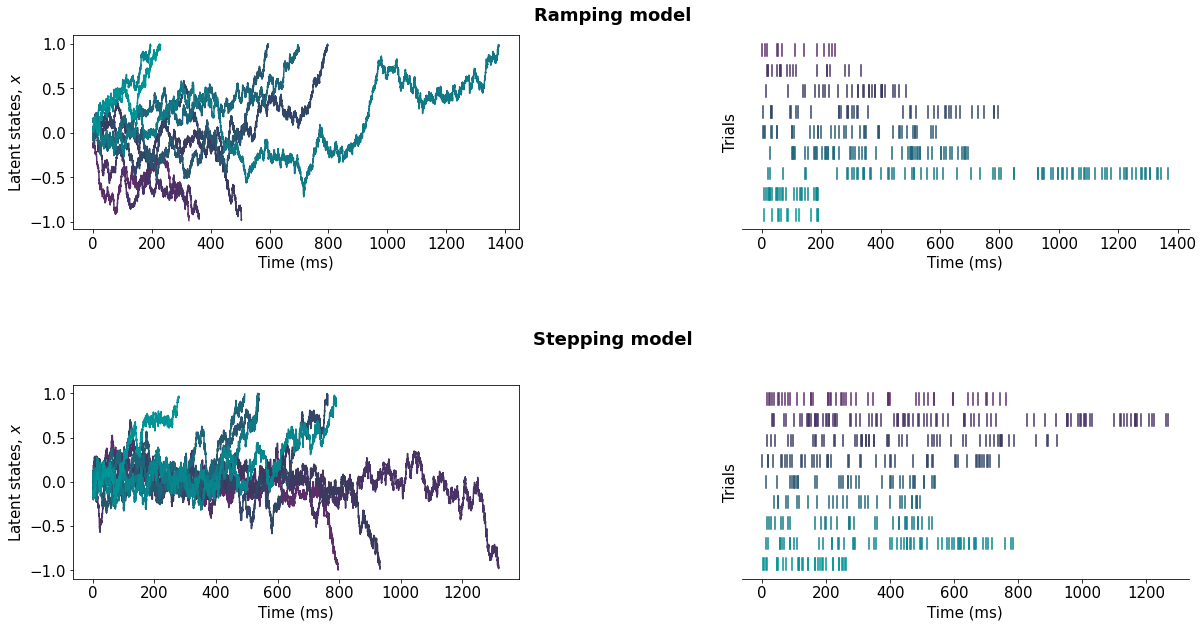

In [4]:
#(OPTIONAL): Visualize the latent trajectories and spike rasters of the generated data
fig=plt.figure(figsize=(20,10))
gs=gridspec.GridSpec(2,2,wspace=0.5, hspace=0.8)
colors=[[0, 0.5804, 0.5922], [0.0353, 0.5216, 0.5569], [0.0667, 0.4745, 0.5255],
[0.1137, 0.4000, 0.4784], [0.1569, 0.3373, 0.4353], [0.1922, 0.2706, 0.4000],
[0.2275, 0.2235, 0.3686], [0.2824, 0.2000, 0.3922], [0.3608, 0.1804, 0.4118]]
colors.reverse()

#Plot ramping model
fig.text(0.5,0.9,'Ramping model',fontsize=18,horizontalalignment='center',fontweight='bold')

#Find where each of the latent trajectories teminate (1 if the right boundary, -1 if the left boundary):
bnd=np.array([1 if diff_traj_ramping[i][-1]>0 else -1 for i in range(len(data_gen_params['time_epoch']))])

# Take 3 example trajectories that terminate on the left boundary, and 6 that terminate on the right boundary
if np.where(bnd==-1)[0].size<3:
    print('Due to bad luck there are less than 3 trials out of 200 that terminate on the left boundary. Please rerun the previous cell to generate new data, and then rerun this cell')
traj_indeces=np.concatenate((np.where(bnd==-1)[0][:3],np.where(bnd==1)[0][:6]))

#Plot latent trajectories
ax = plt.subplot(gs[0])
for i in range(9):
    plt.plot(time_bins_ramping[traj_indeces[i]]*1000,diff_traj_ramping[traj_indeces[i]],color=colors[i])
plt.xlabel('Time (ms)',fontsize=15)
plt.ylabel(r'Latent states, $x$',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)

#Plot spikes
ax = plt.subplot(gs[1])
plot_spikes(spikes_ramping[list(traj_indeces)],ax,colors)
plt.xlabel('Time (ms)',fontsize=15)
plt.ylabel('Trials',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)

#Plot stepping model
fig.text(0.5,0.45,'Stepping model',fontsize=18,horizontalalignment='center',fontweight='bold')

#Find where each of the latent trajectories teminate (1 if the right boundary, -1 if the left boundary):
bnd=np.array([1 if diff_traj_stepping[i][-1]>0 else -1 for i in range(len(data_gen_params['time_epoch']))])

# Take 3 example trajectories that terminate on the left boundary, and 6 that terminate on the right boundary
if np.where(bnd==-1)[0].size<3:
    print('Due to bad luck there are less than 3 trials out of 200 that terminate on the left boundary. Please rerun the previous cell to generate new data, and then rerun this cell')
traj_indeces=np.concatenate((np.where(bnd==-1)[0][:3],np.where(bnd==1)[0][:6]))

#Plot latent trajectories
ax = plt.subplot(gs[2])
for i in range(9):
    plt.plot(time_bins_stepping[traj_indeces[i]]*1000,diff_traj_stepping[traj_indeces[i]],color=colors[i])
plt.xlabel('Time (ms)',fontsize=15)
plt.ylabel(r'Latent states, $x$',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = plt.subplot(gs[3])

#Plot spikes
plot_spikes(spikes_stepping[list(traj_indeces)],ax,colors)

plt.xlabel('Time (ms)',fontsize=15)
plt.ylabel('Trials',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)

The code above should produce the following image:
![FIG4_1](Example4_1.png)

## Step 2: Optimize the model potentials using the generated data

1) Specify the EnergyModel variable for fitting. All parameters are the same as the ground-truth, but the initial guesses for the potential are the constant potentials (uniform peq models). To accelerate the evaluation of this cell, we also reduce grid resolution.

2) Specify options. Here we want to optimize the model with the following assumptions: absorbing boundary mode, with the correct p0 distribution, and with the absorption operator (`absorption_event=True`). To accelerate computation time, we set max_iteration to 50, however, you may want to increase it.

3) Optimize the model with the selected parameters.

4) Visualise the results.

In [5]:
#Ramping model
EnergyModelParams={'pde_solve_param':{'method':{'name': 'SEM', 'gridsize': {'Np': 8, 'Ne': 16}}}, 
               'Nv': 111,  
               'peq_model':{"model": "uniform", "params": {}},
               'D0': 0.56,
               'p0_model':{"model": "single_well", "params": {"miu": 200, "xmin": 0}},
               'boundary_mode':'absorbing', 
               'num_neuron':1,
               'firing_model':[{"model": "linear", "params": {"r_slope": 50, "r_bias": 60}}],
               'verbose':True
               }
em_fit_ramping=neuralflow.EnergyModel(**EnergyModelParams)

options_ramping={}
options_ramping['data']={'dataTR':spikes_ramping}
options_ramping['save']=None
options_ramping['inference']={'metadataTR':{'last_event_is_spike':False,'absorption_event':True}}
options_ramping['optimization']={'gamma':{'F':0.0025},'max_iteration':50,'loglik_tol':0,'etaf':0}

em_fit_ramping.fit('GD',options_ramping);

#Stepping model
EnergyModelParams={'pde_solve_param':{'method':{'name': 'SEM', 'gridsize': {'Np': 8, 'Ne': 16}}}, 
               'Nv': 111,  
               'peq_model':{"model": "uniform", "params": {}},
               'D0': 1,
               'p0_model':{"model": "single_well", "params": {"miu": 200, "xmin": 0}},
               'boundary_mode':'absorbing', 
               'num_neuron':1,
               'firing_model':[{"model": "linear", "params": {"r_slope": 50, "r_bias": 60}}],
               'verbose':True
               }
em_fit_stepping=neuralflow.EnergyModel(**EnergyModelParams)

options_stepping={}
options_stepping['data']={'dataTR':spikes_stepping}
options_stepping['save']=None
options_stepping['inference']={'metadataTR':{'last_event_is_spike':False,'absorption_event':True}}
options_stepping['optimization']={'gamma':{'F':0.0025},'max_iteration':100,'loglik_tol':0,'etaf':0}

em_fit_stepping.fit('GD',options_stepping);

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:27<00:00,  2.07s/it]


Text(0.5, 0.45, 'Stepping')

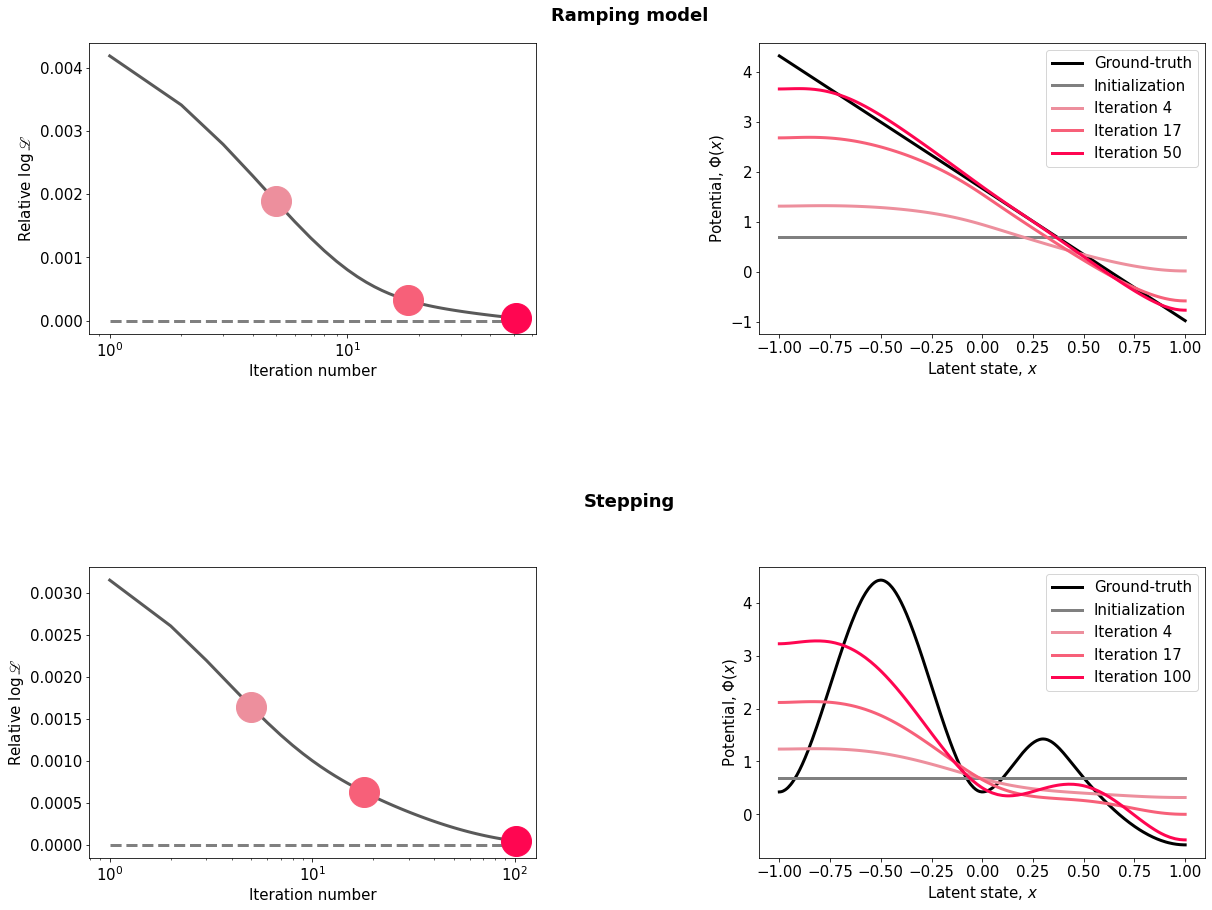

In [6]:
#Visualize the results
#Create a big figure to plot all the results
fig=plt.figure(figsize=(20,15))
gs=gridspec.GridSpec(2,2,wspace=0.5,hspace=0.8);
colors=[[0.9294, 0.5608, 0.6157], [0.9686, 0.3765, 0.4745], [1.0000, 0.0235, 0.3176]]
example_iterations_ramping=[4,17,em_fit_ramping.iterations_GD_['logliks'].size-1]
#Plot the results for ramping model
plot_fitting_results(gs[0],gs[1],em_fit_ramping,em_gt_ramping,options_ramping,example_iterations_ramping,colors)
fig.text(0.5,0.9,'Ramping model',fontsize=18,horizontalalignment='center',fontweight='bold')
#Plot the results for stepping model
example_iterations_stepping=[4,17,em_fit_stepping.iterations_GD_['logliks'].size-1]
plot_fitting_results(gs[2],gs[3],em_fit_stepping,em_gt_stepping,options_stepping,example_iterations_stepping,colors)
fig.text(0.5,0.45,'Stepping',fontsize=18,horizontalalignment='center',fontweight='bold')

The code above should produce the following image:
![FIG4_2](Example4_2.png)

## Step 3: Optimize the model potential, the initial latent state distribution, and D from data

1) Specify the EnergyModel variable for fitting. This time the initial guesses for the model potential, D, and p0 will differ from the ground-truth.

2) Specify options. Here we want to optimize the model under the following assumptions: absorbing boundary mode, and with the absorption operator (`absorption_event=True`). To accelerate computation time, we set max_iteration to 50, however, you may want to increase it.

3) Optimize the model with the selected parameters.

4) Visualise the results.

In [7]:
EnergyModelParams={'pde_solve_param':{'method':{'name': 'SEM', 'gridsize': {'Np': 8, 'Ne': 16}}}, 
               'Nv': 111,  
               'peq_model':{"model": "uniform", "params": {}},
               'D0': 1,
               'p0_model':{"model": "uniform", "params": {}},
               'boundary_mode':'absorbing', 
               'num_neuron':1,
               'firing_model':[{"model": "linear", "params": {"r_slope": 50, "r_bias": 60}}],
               'verbose':True
               }
em_fit_ramping=neuralflow.EnergyModel(**EnergyModelParams)

options_ramping={}
options_ramping['data']={'dataTR':spikes_ramping}
options_ramping['save']=None
options_ramping['inference']={'metadataTR':{'last_event_is_spike':False,'absorption_event':True}}
options_ramping['optimization']={'gamma':{"F": 0.0012, "F0": 0.025, "D": 0.00025},'max_iteration':100,'loglik_tol':0,'etaf':0}

em_fit_ramping.fit('GD',options_ramping);

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:40<00:00,  2.20s/it]


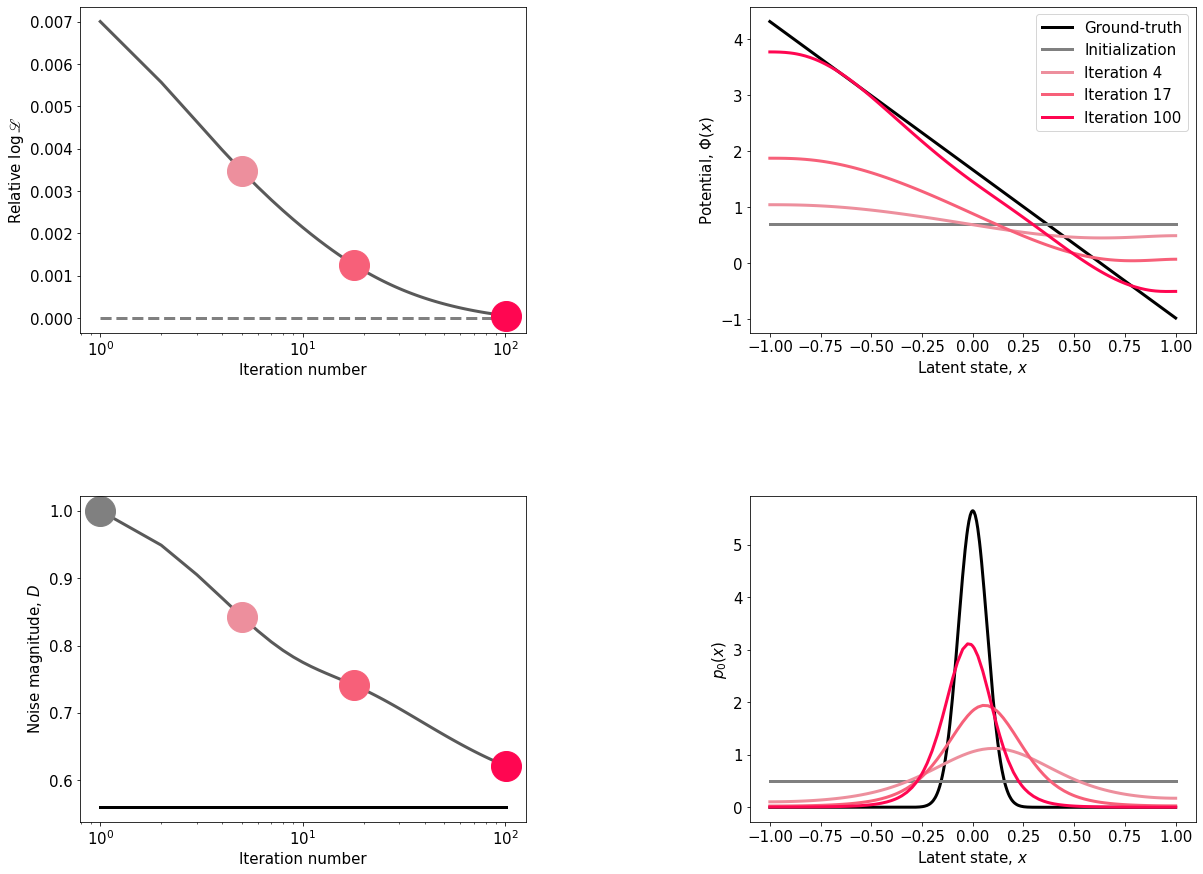

In [8]:
#Visualise the results
fig=plt.figure(figsize=(20,15))
gs=gridspec.GridSpec(2,2,wspace=0.5,hspace=0.5);
example_iterations=[4,17,em_fit_ramping.iterations_GD_['logliks'].size-1]
#Plot the results for ramping model
plot_fitting_results(gs[0],gs[1],em_fit_ramping,em_gt_ramping,options_ramping,example_iterations,colors)

#Plot D 
ax = plt.subplot(gs[2])
iterations_all=em_fit_ramping.iterations_GD_['iter_num']+1
ax.plot(iterations_all,em_fit_ramping.iterations_GD_['Ds'],linewidth=3,color=[0.35,0.35,0.35])
ax.plot(iterations_all[0],em_fit_ramping.iterations_GD_['Ds'][0],'.',markersize=60,color=[0.5,0.5,0.5])
ax.plot(iterations_all,em_gt_ramping.D_*np.ones_like(iterations_all),'-',linewidth=3,color='black')
for i,iteration in enumerate(example_iterations):
    ax.plot(iterations_all[iteration],em_fit_ramping.iterations_GD_['Ds'][iteration],'.',markersize=60,color=colors[i])

    
plt.ylabel(r'Noise magnitude, $D$',fontsize=15)
plt.xlabel('Iteration number',fontsize=15)
plt.xscale('log')
ax.tick_params(axis='both', which='major', labelsize=15)

#Plot p0
ax = plt.subplot(gs[3])
ax.plot(em_gt_ramping.x_d_,em_gt_ramping.p0_,linewidth=3,color='black',label='Ground-truth')
ax.plot(em_fit_ramping.x_d_,em_fit_ramping.iterations_GD_['p0s'][...,0],linewidth=3,color=[0.5,0.5,0.5],label='Initialization')
for i,iteration in enumerate(example_iterations):
    ax.plot(em_fit_ramping.x_d_,em_fit_ramping.iterations_GD_['p0s'][...,iteration],linewidth=3,color=colors[i],label='Iteration {}'.format(iteration))
#plt.legend(fontsize=15)
plt.xlabel(r'Latent state, $x$',fontsize=15)
plt.ylabel(r'$p_0(x)$',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)

The code above should produce the following image:
![FIG4_3](Example4_3.png)